In [2]:
import pandas as pd

df = pd.read_csv("lightcast_job_postings.csv")

columns_to_drop = [
    "ID", "URL", "ACTIVE_URLS", "DUPLICATES", "LAST_UPDATED_TIMESTAMP",
    "NAICS2", "NAICS3", "NAICS4", "NAICS5", "NAICS6",
    "SOC_2", "SOC_3", "SOC_5"
]
valid_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=valid_cols_to_drop, inplace=True)

df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)

if "SALARY" in df.columns:
    df["SALARY"].fillna(df["SALARY"].median(), inplace=True)
if "Industry" in df.columns:
    df["Industry"].fillna("Unknown", inplace=True)

df.drop_duplicates(subset=["TITLE", "COMPANY", "LOCATION", "POSTED"], keep="first", inplace=True)

if "POSTED" in df.columns:
    df['POSTED'] = pd.to_datetime(df['POSTED'], errors='coerce')

/var/folders/z6/j54j6tys1bbdr2gqg5vfm6tw0000gn/T/ipykernel_13534/705840187.py:3: DtypeWarning: Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("lightcast_job_postings.csv")


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [6]:
cols_to_use = ['NAICS_2022_5_NAME', 'EMPLOYMENT_TYPE_NAME', 'REMOTE_TYPE_NAME', 'EDUCATION_LEVELS_NAME']

df_kmeans = df[cols_to_use].dropna()

In [7]:
X = pd.get_dummies(df_kmeans)

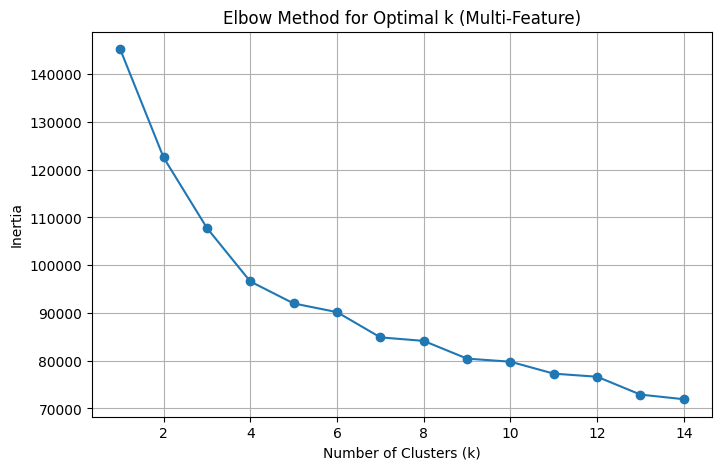

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(1, 15) 

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (Multi-Feature)')
plt.grid(True)
plt.show()

In [9]:
k_optimal = 4

kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df_kmeans['cluster'] = kmeans_final.fit_predict(X)

print(df_kmeans['cluster'].value_counts())

cluster
0    23580
2    18064
3    15794
1    11743
Name: count, dtype: int64


In [11]:
print(df_kmeans.head())

                            NAICS_2022_5_NAME    EMPLOYMENT_TYPE_NAME  \
0  Automotive Parts and Accessories Retailers  Full-time (> 32 hours)   
1                     Temporary Help Services  Full-time (> 32 hours)   
2          Other Insurance Related Activities  Full-time (> 32 hours)   
3                          Commercial Banking  Full-time (> 32 hours)   
4                       Unclassified Industry   Part-time / full-time   

  REMOTE_TYPE_NAME          EDUCATION_LEVELS_NAME  cluster  
0           [None]    [\n  "Bachelor's degree"\n]        0  
1           Remote  [\n  "No Education Listed"\n]        1  
2           [None]    [\n  "Bachelor's degree"\n]        0  
3           [None]  [\n  "No Education Listed"\n]        2  
4           [None]  [\n  "No Education Listed"\n]        2  


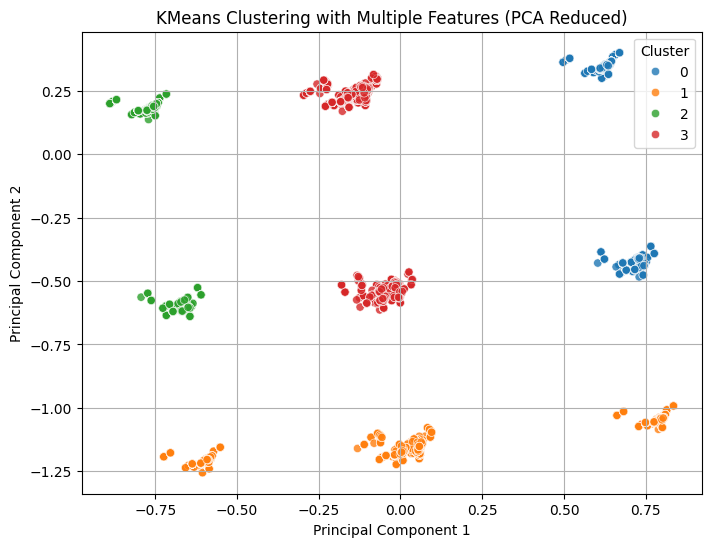

In [10]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = df_kmeans['cluster'].values

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='cluster',
    palette='tab10',
    data=pca_df,
    legend='full',
    alpha=0.8
)
plt.title('KMeans Clustering with Multiple Features (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [12]:
features = ['NAICS_2022_5_NAME', 'EMPLOYMENT_TYPE_NAME', 'REMOTE_TYPE_NAME', 'EDUCATION_LEVELS_NAME']

profile_summary = []

for cluster_label in sorted(df_kmeans['cluster'].unique()):
    cluster_data = df_kmeans[df_kmeans['cluster'] == cluster_label]
    
    top_features = {}
    for feature in features:
        if cluster_data[feature].nunique() > 0:
            if feature == 'EDUCATION_LEVELS_NAME':
                clean_edu = cluster_data[feature].astype(str).str.replace(r'[\[\]\n\"]', '', regex=True)  # 去掉[], \n, "这些符号
                clean_edu = clean_edu.str.split(',').str[0] 
                top_features[feature] = clean_edu.value_counts().idxmax()
            else:
                top_features[feature] = cluster_data[feature].value_counts().idxmax()
        else:
            top_features[feature] = 'N/A'
    
    profile_summary.append({
        'Cluster': cluster_label,
        'Top NAICS_2022_5_NAME': top_features['NAICS_2022_5_NAME'],
        'Top Employment Type': top_features['EMPLOYMENT_TYPE_NAME'],
        'Top Remote Type': top_features['REMOTE_TYPE_NAME'],
        'Top Education Level': top_features['EDUCATION_LEVELS_NAME']
        })

profile_df = pd.DataFrame(profile_summary)

print(profile_df)

   Cluster                         Top NAICS_2022_5_NAME  \
0        0                         Unclassified Industry   
1        1                         Unclassified Industry   
2        2  Computer Systems Design and Related Services   
3        3  Computer Systems Design and Related Services   

      Top Employment Type Top Remote Type    Top Education Level  
0  Full-time (> 32 hours)          [None]      Bachelor's degree  
1  Full-time (> 32 hours)          Remote      Bachelor's degree  
2  Full-time (> 32 hours)          [None]    No Education Listed  
3  Full-time (> 32 hours)          [None]      Bachelor's degree  


In this project, we used the KMeans clustering model to group job postings based on several key features: industry classification (NAICS codes), employment type (full-time or part-time), remote work type (remote, on-site, or hybrid), and minimum education requirements (such as bachelor’s or master’s degrees).
The purpose of clustering was to identify distinct groups within the job market and provide more targeted career insights and recommendations for job seekers.

We selected four features for clustering: NAICS_2022_5_NAME, EMPLOYMENT_TYPE_NAME, REMOTE_TYPE_NAME, and EDUCATION_LEVELS_NAME.
After applying one-hot encoding to these categorical variables, we used the KMeans algorithm to build the model.
To determine the optimal number of clusters, we used the Elbow Method and selected k=4, which divided the data into four distinct job groups.
We then reduced the dimensionality of the clustered data to two components using PCA and visualized the results.
The clusters were clearly separated and showed good internal consistency.

Through analysis of the clustering results, we found the following:
Cluster 0 mainly consists of jobs classified under “Unclassified Industry,” with most being full-time positions, low levels of remote work, and a majority requiring a bachelor’s degree.
Cluster 1 also contains jobs from unclassified industries, but with a higher proportion of remote work opportunities, making it suitable for those who prefer remote jobs.
Clusters 2 and 3 are primarily composed of jobs in “Computer Systems Design and Related Services,” with higher education requirements, often needing a master’s degree or higher.
These clusters are more appropriate for technical job seekers.

Based on the cluster characteristics, we recommend that job seekers who prefer remote work focus on opportunities within Cluster 1.
Those with advanced degrees and technical backgrounds should prioritize jobs in Clusters 2 and 3.
Entry-level candidates or those with lower education requirements may find suitable opportunities in Cluster 0.

In [13]:
import pandas as pd

df = pd.read_csv("lightcast_job_postings.csv")

columns_to_drop = [
    "ID", "URL", "ACTIVE_URLS", "DUPLICATES", "LAST_UPDATED_TIMESTAMP",
    "NAICS2", "NAICS3", "NAICS4", "NAICS5", "NAICS6",
    "SOC_2", "SOC_3", "SOC_5"
]
valid_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=valid_cols_to_drop, inplace=True)

if "SALARY" in df.columns:
    df["SALARY"].fillna(df["SALARY"].median(), inplace=True)
if "Industry" in df.columns:
    df["Industry"].fillna("Unknown", inplace=True)
df["MIN_YEARS_EXPERIENCE"] = df["MIN_YEARS_EXPERIENCE"].fillna(df["MIN_YEARS_EXPERIENCE"].median())

df.drop_duplicates(subset=["TITLE", "COMPANY", "LOCATION", "POSTED"], keep="first", inplace=True)

if "POSTED" in df.columns:
    df['POSTED'] = pd.to_datetime(df['POSTED'], errors='coerce')

/var/folders/z6/j54j6tys1bbdr2gqg5vfm6tw0000gn/T/ipykernel_13534/2645817170.py:3: DtypeWarning: Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("lightcast_job_postings.csv")
/var/folders/z6/j54j6tys1bbdr2gqg5vfm6tw0000gn/T/ipykernel_13534/2645817170.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["SALARY"].fillna(df["SALARY"].median(), inplace=True)


In [14]:
cols_to_check = [
    'EMPLOYMENT_TYPE_NAME', 
    'REMOTE_TYPE_NAME', 
    'EDUCATION_LEVELS_NAME', 
    'NAICS_2022_5_NAME', 
    'TITLE_NAME', 
    'SALARY',
    'MIN_YEARS_EXPERIENCE'
]

missing_counts = df[cols_to_check].isnull().sum()

print(missing_counts)

EMPLOYMENT_TYPE_NAME     17
REMOTE_TYPE_NAME         17
EDUCATION_LEVELS_NAME    17
NAICS_2022_5_NAME        17
TITLE_NAME               17
SALARY                    0
MIN_YEARS_EXPERIENCE      0
dtype: int64


In [15]:
cols_to_use = [
    'EMPLOYMENT_TYPE_NAME', 
    'REMOTE_TYPE_NAME', 
    'EDUCATION_LEVELS_NAME',  
    'TITLE_NAME', 
    'NAICS_2022_5_NAME',
    'SALARY'
]
df_regression = df[cols_to_use].dropna()

y = df_regression['SALARY']

X = pd.get_dummies(df_regression.drop('SALARY', axis=1), drop_first=True)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=688)

In [17]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [18]:
y_pred = lr_model.predict(X_test)

In [19]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

RMSE: 24855.89
R²: 0.2912


In [20]:
import pandas as pd

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
})

coef_df['Coefficient_Abs'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Coefficient_Abs', ascending=False)

print(coef_df.head(20))

                                        Feature    Coefficient  \
5571          TITLE_NAME_Urgent Care Physicians  251386.121082   
3976           TITLE_NAME_Portfolio Strategists  218543.202752   
677    TITLE_NAME_Business Performance Analysts  200638.126095   
4260           TITLE_NAME_Psychiatry Physicians  198843.552601   
3135        TITLE_NAME_Lead Security Architects  189207.776080   
4020         TITLE_NAME_Primary Care Physicians  157627.519893   
1699  TITLE_NAME_Digital Verification Engineers  153248.368916   
866       TITLE_NAME_Certified Tumor Registrars  144003.199611   
1759   TITLE_NAME_Directors of Global Logistics  138363.896627   
5113              TITLE_NAME_Staff IT Engineers  133667.627850   
2085    TITLE_NAME_Enterprise Services Managers  133393.234468   
2169    TITLE_NAME_Executive Business Directors  131837.191508   
5668      TITLE_NAME_Water/Wastewater Engineers  131641.345181   
893         TITLE_NAME_Chief Systems Architects  130059.716545   
3209      

In this project, we used a linear regression model to predict salary levels based mainly on the job title feature (TITLE_NAME). The model results show that roles in healthcare, such as Urgent Care Physicians and Psychiatry Physicians, as well as positions in finance like Portfolio Strategists and IT security roles like Lead Security Architects, have a strong positive impact on salary levels. This means that jobs requiring high specialization and in-demand skills tend to offer higher salaries.
For job seekers, these findings provide useful guidance for career planning and salary expectations. People who aim for higher-paying jobs might consider focusing on fields like healthcare, finance, or IT security. However, it is also important to understand that these roles often come with higher professional requirements and work pressure. When making career choices, it is important to match personal interests, skills, and strengths with realistic goals. Companies can also use this insight to better design competitive salary strategies and attract top talent.

In [23]:
import plotly.express as px

results_df = pd.DataFrame({
    'Actual Salary': y_test,
    'Predicted Salary': y_pred
})

fig = px.scatter(
    results_df, 
    x='Actual Salary', 
    y='Predicted Salary',
    title="Actual vs Predicted Salaries",
    labels={"x": "Actual Salary", "y": "Predicted Salary"},
    template="plotly_white"
)

fig.add_shape(
    type='line',
    x0=results_df['Actual Salary'].min(), y0=results_df['Actual Salary'].min(),
    x1=results_df['Actual Salary'].max(), y1=results_df['Actual Salary'].max(),
    line=dict(color='red', dash='dash')
)

fig.show()

The scatter plot shows the model’s prediction performance. The x-axis represents the actual salary, and the y-axis shows the predicted salary. The red dashed line represents a perfect prediction line. Overall, the model captures the general trend of salary changes fairly well. However, in the higher salary range, especially for jobs over 200,000 dollars per year, the model tends to underestimate salaries and shows larger prediction errors. In the lower salary range, especially for jobs below 100,000 dollars, the model predicts more accurately.

This suggests that while the model provides helpful salary estimates, job seekers should use it carefully, especially when applying for high-paying positions. It is important to also consider personal background, industry trends, and specific job requirements. For those targeting high salaries, additional preparation, such as improving professional skills and gaining more experience, can help address the model's potential underestimation.

In [24]:
import plotly.graph_objects as go

feature_importance = pd.Series(lr_model.coef_, index=X_train.columns)

feature_importance = feature_importance.abs().sort_values(ascending=False).head(20)

fig = go.Figure(go.Bar(
    x=feature_importance.values,
    y=feature_importance.index,
    orientation='h'
))

fig.update_layout(
    title="Top 20 Feature Importances (Linear Regression Coefficients)",
    xaxis_title="Coefficient Magnitude",
    yaxis_title="Features",
    template="plotly_white"
)

fig.show()

From the feature importance chart, we can see that the model's explanation of salary differences is highly concentrated around a small group of high-impact job titles. This suggests that selecting roles in key industries like healthcare, finance, and IT can significantly influence salary outcomes.

For job seekers, aiming for these impactful roles can greatly improve earning potential. On the other hand, for roles with lower feature importance, it might be a good idea to adjust salary expectations based on the broader market. People working in these positions can also consider developing new skills or transitioning into fields with stronger market demand to boost their career development and salary prospects.